### Importar base de dados e instalar framework de recomendação

### Importar bibliotecas

In [67]:
# import wget
!pip install wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz


Saved under ml-20m-compact.tar (1).gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [68]:
import sys
!{sys.executable} -m pip install caserecommender

In [69]:
import pandas as pd
import numpy as np

### Explorar Dados

In [70]:
movies = pd.read_csv('./dataset/movies_sample.csv')
movies.tail()

,movieId,title,genres
428,129857,Bright Days Ahead (2013),Drama|Romance
429,130344,Coast of Death (2013),Children|Documentary|Drama
430,130408,A Rumor Of War (1980),(no genres listed)
431,130510,Berserk: The Golden Age Arc 3 - Descent (2013),Action|Animation|Fantasy
432,131239,Three Quarter Moon (2011),Comedy|Drama


In [71]:
ratings = pd.read_csv('./dataset/ratings_sample.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,11,7481,5.0,1230788624
1,11,1046,4.5,1251144145
2,11,616,4.0,1230782542
3,11,3535,2.0,1230784884
4,11,5669,5.0,1230853788


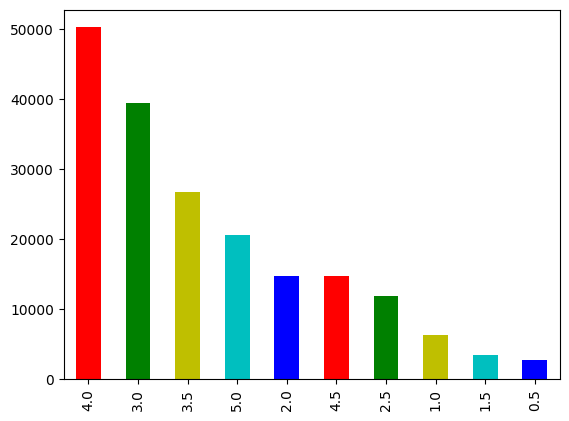

In [72]:
import matplotlib.pyplot as plt
ratings.rating.value_counts().plot(kind='bar', color=['r', 'g', 'y', 'c', 'b']);
plt.show()

In [73]:
df = ratings[['userId', 'movieId', 'rating']]
df.tail()

,userId,movieId,rating
190616,138493,288,5.0
190617,138493,1748,5.0
190618,138493,616,4.0
190619,138493,1597,4.5
190620,138493,7371,5.0


In [74]:
df = df.merge(movies[['movieId', 'title']])
df.head()

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,359,7481,4.0,Enemy Mine (1985)
2,422,7481,3.0,Enemy Mine (1985)
3,424,7481,3.0,Enemy Mine (1985)
4,744,7481,3.0,Enemy Mine (1985)


### Números de usuários e número de itens

In [75]:
print(
"""
Número de usuários: {}
Número de itens: {}
Número de interações: {}
""".format(
    df.userId.nunique(),
    df.movieId.nunique(),
    df.shape[0]
)
)


Número de usuários: 11090
Número de itens: 417
Número de interações: 190621



### Mapeamento em idx

In [76]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}

In [77]:
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
df.head()

,userId,movieId,rating,title
0,0,0,5.0,Enemy Mine (1985)
1,1,0,4.0,Enemy Mine (1985)
2,2,0,3.0,Enemy Mine (1985)
3,3,0,3.0,Enemy Mine (1985)
4,4,0,3.0,Enemy Mine (1985)


In [78]:
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title

In [79]:
print(len(map_title))
print(map_title[100])

417
Send Me No Flowers (1964)


In [80]:
# qtd interações dos usuários
df.groupby('userId').count()

,movieId,rating,title
userId,,,
0,13,13,13
1,25,25,25
2,14,14,14
3,25,25,25
4,11,11,11
...,...,...,...
11085,11,11,11
11086,10,10,10
11087,25,25,25


### Divisão do dataset

In [81]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)
train.to_csv('train.txt', index=False, header=False, sep='\t')
test.to_csv('test.txt', index=False, header=False, sep='\t')

In [82]:
! ls -l

total 137680
drwxr-xr-x 2  501 staff     4096 Mar 17  2022  dataset
-rw-r--r-- 1 root root  65019041 Aug 21 12:00 'ml-20m-compact.tar (1).gz'
-rw-r--r-- 1 root root  65019041 Aug 21 11:39  ml-20m-compact.tar.gz
-rw-r--r-- 1 root root   2188701 Aug 21 11:41  out_mp_pred_binary.txt
-rw-r--r-- 1 root root    644050 Aug 21 11:41  out_mp_pred.txt
-rw-r--r-- 1 root root    644050 Aug 21 11:42  rp_iknn.txt
drwxr-xr-x 1 root root      4096 Aug 17 13:29  sample_data
-rw-r--r-- 1 root root   1490769 Aug 21 12:00  test.txt
-rw-r--r-- 1 root root   5951786 Aug 21 12:00  train.txt


In [83]:
print('No. items: ' + str(train['movieId'].nunique()))
print('No. users: ' + str(train['userId'].nunique()))

No. items: 403
No. users: 11090


### Recomendadores

## Prever notas

In [84]:
from caserec.recommenders.rating_prediction.most_popular import MostPopular

In [85]:
MostPopular('train.txt', 'test.txt', 'out_mp_pred.txt').compute()

[Case Recommender: Rating Prediction > Most Popular]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

prediction_time:: 89.528046 sec


Eval:: MAE: 0.703266 RMSE: 0.910252 


In [86]:
df_pred = pd.read_csv('out_mp_pred.txt', sep='\t', names=['userId', 'movieId', 'pred'])
df_pred.head(10)

,userId,movieId,pred
0,0,0,3.443980
1,0,5,3.333857
2,1,6,3.573171
3,1,106,3.290084
4,1,21,3.211811
5,1,30,3.651042
6,1,12,4.176005
7,2,30,3.651042
8,2,42,3.513158
9,2,69,2.475379


In [87]:
test[test.userId == 1]

,userId,movieId,rating,title
17476,1,6,4.5,Apocalypto (2006)
172435,1,106,2.5,Shopgirl (2005)
75352,1,21,2.5,Conspiracy Theory (1997)
103814,1,30,3.5,Collateral (2004)
31545,1,12,4.0,Star Wars: Episode V - The Empire Strikes Back...


In [88]:
df_pred = df_pred.merge(test)

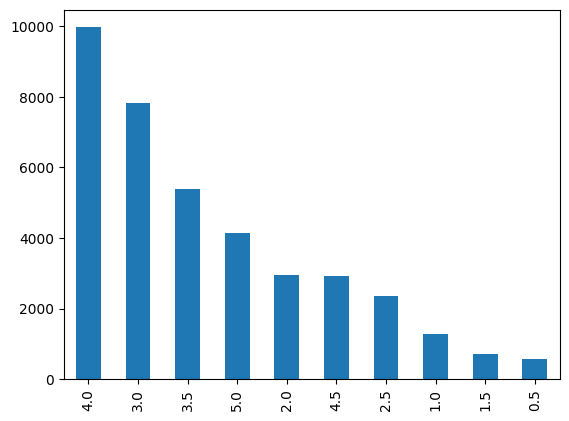

In [89]:
df_pred.rating.value_counts().plot(kind='bar')
plt.show()

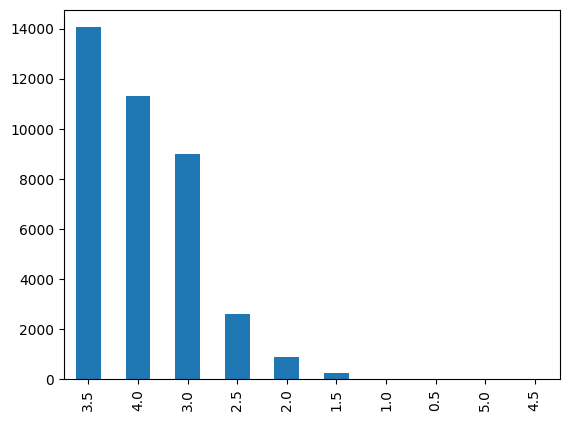

In [90]:
df_pred['pred'] = round(df_pred['pred']*2)/2
df_pred.pred.value_counts().plot(kind='bar');
plt.show()

### Top N

In [91]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular as MPR

In [92]:
MPR('train.txt', 'test.txt', 'out_mp_pred_binary.txt', as_binary=True).compute()

[Case Recommender: Item Recommendation > Most Popular]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

prediction_time:: 2.269051 sec


Eval:: PREC@1: 0.390555 PREC@3: 0.253801 PREC@5: 0.21312 PREC@10: 0.167009 RECALL@1: 0.123509 RECALL@3: 0.227113 RECALL@5: 0.311363 RECALL@10: 0.481113 MAP@1: 0.390555 MAP@3: 0.458313 MAP@5: 0.463942 MAP@10: 0.437594 NDCG@1: 0.390555 NDCG@3: 0.523907 NDCG@5: 0.549345 NDCG@10: 0.552196 


In [93]:
ranking = pd.read_csv('out_mp_pred_binary.txt', sep='\t', names=['userId', 'movieId', 'score'])
ranking['title'] = ranking.movieId.map(map_title)
ranking.head(15)

,userId,movieId,score,title
0,0,19,6379.0,Reservoir Dogs (1992)
1,0,22,4562.0,Natural Born Killers (1994)
2,0,17,4461.0,Chasing Amy (1997)
3,0,18,4279.0,Life Is Beautiful (La Vita è bella) (1997)
4,0,33,3860.0,North by Northwest (1959)
5,0,21,3666.0,Conspiracy Theory (1997)
6,0,5,3503.0,"I, Robot (2004)"
7,0,20,3471.0,While You Were Sleeping (1995)
8,0,23,3466.0,Crimson Tide (1995)
9,0,28,3344.0,My Best Friend's Wedding (1997)


### Item KNN

In [94]:
from caserec.recommenders.rating_prediction.itemknn import ItemKNN

ItemKNN('train.txt', 'test.txt', 'rp_iknn.txt', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > ItemKNN Algorithm]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

training_time:: 7.007661 sec
prediction_time:: 2.309256 sec
Eval:: MAE: 0.665964 RMSE: 0.876739 


**Exercício 01:**

a) Encontrar o id do usuário que avaliou mais filmes na base. Informe o id externo (da base dados) e o interno (usado pelo recomendador)

In [95]:
# Mount df from scratch
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])

# External user ID
external_user_id = df['userId'].value_counts().idxmax()

# Internal user ID used by recommender
internal_user_id = map_users[external_user_id]

print("External User ID:", external_user_id)
print("Internal User ID:", internal_user_id)

External User ID: 118205
Internal User ID: 1129


b) Encontrar os 5 primeiros usuários que têm maior propensão a dar notas baixas aos filmes (use a média de ratings para isso).

In [96]:
# Calculate users avg rating
user_avg_ratings = df.groupby('userId')['rating'].mean()

# Find 5 lowest average ratings users
lowest_rating_users = user_avg_ratings.sort_values()[:5]

print("5 lowest average ratings users (by external id):")
print(lowest_rating_users)

5 lowest average ratings users (by external id):
userId
113857    0.735294
2084      0.961538
83891     1.115385
102570    1.205882
135142    1.307692
Name: rating, dtype: float64


c) Encontrar os 5 filmes pior avaliados pelos usuários.

In [97]:
# (Make sure map_title is implemented correctly by running "Mapeamento em idx" scripts)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title

In [98]:
# Calculate movies avg rating
movie_avg_ratings = df.groupby('movieId')['rating'].mean()

# Find 5 lowest average ratings movies
lowest_rated_movies = movie_avg_ratings.sort_values()[:5]

# (Make sure map_title is implemented correctly by running "Mapeamento em idx" scripts)

# Build two arrays w/ titles and values
lowest_rated_movies_titles = lowest_rated_movies.index.map(map_title)
lowest_rated_movies_avg_ratings = lowest_rated_movies.values

# Display 5 lowest average ratings movies
print("5 lowest average ratings movies:")
for title, avg_rating in zip(lowest_rated_movies_titles, lowest_rated_movies_avg_ratings):
    print()
    print("Movie Title:", title)
    print("Average Rating:", avg_rating)

5 lowest average ratings movies:

Movie Title: Heroic Purgatory (Rengoku eroica) (1970)
Average Rating: 1.0

Movie Title: Snapshot (1979)
Average Rating: 1.0

Movie Title: Hercules (2005)
Average Rating: 1.0

Movie Title: Loaded (2008)
Average Rating: 1.1666666666666667

Movie Title: Entre ses mains (2005)
Average Rating: 1.5


**Exercício 02:** Na aula vimos uma abordagem de recomendação não personalizada que utiliza a quantidade de interações dos itens para recomendar filmes mais populares aos usuários. Quando há feedback explícito, entretanto, a mesma abordagem "Most Popular" pode fazer uso da média das notas disponíveis, ou seja, recomendam-se os N filmes mais bem avaliados a cada usuário. Desse modo, calcule a recomendação de 5 filmes para um usuário qualquer da base considerando essa estratégia não personalizada. Utilize a base toda como conjunto de treinamento.

In [99]:
# (Make sure map_title is implemented correctly by running "Mapeamento em idx" scripts)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title

In [100]:
# (Make sure map_title is implemented correctly by running "Mapeamento em idx" scripts)

average_ratings = df.groupby('movieId')['rating'].mean()
top_rated_movies = average_ratings.nlargest(5).index.tolist()

print("Top Rated Movies for Recommendation:")
for movie_id in top_rated_movies:
    movie_title = map_title[movie_id]
    print("Movie ID:", movie_id, "Title:", movie_title)

# could be improved by calculating unbiased avg for each item
# could also consider number of ratings, recommending based on score = unbiasedAvg * N (N = number of ratings)

Top Rated Movies for Recommendation:
Movie ID: 109529 Title: Everybody Street (2013)
Movie ID: 908 Title: North by Northwest (1959)
Movie ID: 1196 Title: Star Wars: Episode V - The Empire Strikes Back (1980)
Movie ID: 58649 Title: Napoléon (1927)
Movie ID: 7587 Title: Samouraï, Le (Godson, The) (1967)


**Exercício 03:** Com base no código disponível no notebook "Aula01_Exemplos.ipynb", implemente uma função que retorna os k filmes mais similares a um outro qualquer passado como parâmetro.

In [102]:
from statistics import mean
from math import pow, sqrt

# Obter a lista de todos os usuários que avaliaram um filme.
def get_user_ids(movieId):
    if movieId not in df['movieId'].values:
        return []
    return (df.loc[(df.movieId==movieId),'userId'].tolist())

# Obter a lista de ratings de um filme.
def get_ratings(movieId):
    if movieId not in df['movieId'].values:
        return []
    return (df.loc[(df.movieId==movieId),'rating'].tolist())

# Obter a média de ratings de um usuário
def get_movie_mean(movieId):
    return np.mean(get_ratings(movieId))

# Obter a nota que um usuário deu para um item.
def get_rating(userId,movieId):
    if len(df[(df['userId']==userId)&(df['movieId']==movieId)]) == 0:
        return 0
    return (df.loc[(df.userId==userId) & (df.movieId == movieId),'rating'].iloc[0])


def similarity_score(movieId1, movieId2):
    '''
    movieId1 & movieId2 : ids dos dois filmes cuja similaridade será computada
    '''
    # Contar quantos usuários avaliaram ambos os filmes.
    user_list1 = get_user_ids(movieId1)
    user_list2 = get_user_ids(movieId2)
    common_items = list(set(user_list1) & set(user_list2))
    if len(common_items) == 0:
        return 0

    # Calcular o viés de cada filme
    movie1_mean = get_movie_mean(movieId1)
    movie2_mean = get_movie_mean(movieId2)

    # Cálculo da similaridade.
    sim = []
    norm1 = []
    norm2 = []
    for item in common_items:
        rating1 = get_rating(item, movieId1)
        rating2 = get_rating(item, movieId2)
        sim.append((rating1 - movie1_mean)*(rating2 - movie2_mean))
        norm1.append(pow(rating1 - movie1_mean, 2))
        norm2.append(pow(rating2 - movie2_mean, 2))

    if(sum(sim)==0): return 0
    return sum(sim) / (sqrt(sum(norm1)) * sqrt(sum(norm2)))

similarity_score(1196, 908)

0.18703120295001233